In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime

In [16]:
ls

 C 드라이브의 볼륨에는 이름이 없습니다.
 볼륨 일련 번호: 12C4-CBD6

 C:\Users\wnsdy\LSTM_Stock 디렉터리

2021-10-21  오후 04:32    <DIR>          .
2021-10-21  오후 04:32    <DIR>          ..
2021-10-21  오후 03:49    <DIR>          .ipynb_checkpoints
2021-10-21  오후 03:50            13,265 005930.KS_1y.csv
2021-10-21  오후 04:07            43,226 1_Asian economy.csv
2021-10-21  오후 04:32            72,041 LSTM_Stock.ipynb
               3개 파일             128,532 바이트
               3개 디렉터리  18,334,486,528 바이트 남음


In [17]:
stock_data = pd.read_csv('./1_Asian economy.csv', encoding='cp949')
stock_data.head()

,일자,종가,대비,등락률,시가,고가,저가,거래량,거래대금,시가총액,상장주식수
0,2021/10/15,3780,50,1.34,3745,3805,3650,187163,697950175,96423014520,25508734
1,2021/10/14,3730,210,5.97,3520,3920,3520,599022,2256149880,95147577820,25508734
2,2021/10/13,3520,140,4.14,3380,3545,3350,174042,605904335,89790743680,25508734
3,2021/10/12,3380,-185,-5.19,3510,3550,3330,244996,833627520,86219520920,25508734
4,2021/10/08,3565,195,5.79,3465,3650,3315,402847,1399127475,90938636710,25508734


In [18]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430 entries, 0 to 429
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일자      430 non-null    object 
 1   종가      430 non-null    int64  
 2   대비      430 non-null    int64  
 3   등락률     430 non-null    float64
 4   시가      430 non-null    int64  
 5   고가      430 non-null    int64  
 6   저가      430 non-null    int64  
 7   거래량     430 non-null    int64  
 8   거래대금    430 non-null    int64  
 9   시가총액    430 non-null    int64  
 10  상장주식수   430 non-null    int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 37.1+ KB


In [19]:
# drop 함수를 사용하여 불필요한 정보의 column 데이터를 삭제
stock_del_column = stock_data.drop(columns = ['대비', '등락률', '거래대금', '시가총액', '상장주식수'])

In [20]:
# rename()을 이용하여 한글로 된 컬럼명을 영어로 바꿈
stock_del_column = stock_del_column.rename(columns = {'일자':'Date', '시가':'Open', '고가':'High',
                                                       '저가':'Low', '종가':'Close', '거래량':'Volumn'})

In [21]:
stock_del_column.head()

,Date,Close,Open,High,Low,Volumn
0,2021/10/15,3780,3745,3805,3650,187163
1,2021/10/14,3730,3520,3920,3520,599022
2,2021/10/13,3520,3380,3545,3350,174042
3,2021/10/12,3380,3510,3550,3330,244996
4,2021/10/08,3565,3465,3650,3315,402847


In [22]:
high_prices = stock_del_column['High'].values
low_prices = stock_del_column['Low'].values
mid_prices = (high_prices + low_prices) / 2

In [23]:
seq_len = 30
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index:index + sequence_length])

In [24]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((359, 30, 1), (40, 30, 1))

In [25]:
model = Sequential()

model.add(LSTM(30, return_sequences=True, input_shape=(30, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24320     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test), batch_size=10, epochs=20)

Epoch 1/20
36/36 [==============================] - 3s 25ms/step - loss: 0.0112 - val_loss: 0.0482
Epoch 2/20
36/36 [==============================] - 0s 13ms/step - loss: 0.0060 - val_loss: 0.0350
Epoch 3/20
36/36 [==============================] - 0s 12ms/step - loss: 0.0046 - val_loss: 0.0221
Epoch 4/20
36/36 [==============================] - 0s 12ms/step - loss: 0.0040 - val_loss: 0.0109
Epoch 5/20
36/36 [==============================] - 0s 12ms/step - loss: 0.0033 - val_loss: 0.0098
Epoch 6/20
36/36 [==============================] - 0s 12ms/step - loss: 0.0032 - val_loss: 0.0091
Epoch 7/20
36/36 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 0.0190
Epoch 8/20
36/36 [==============================] - 0s 12ms/step - loss: 0.0026 - val_loss: 0.0104
Epoch 9/20
36/36 [==============================] - 0s 12ms/step - loss: 0.0025 - val_loss: 0.0068
Epoch 10/20
36/36 [==============================] - 0s 12ms/step - loss: 0.0024 - val_loss: 0.0055
Epoch 11/

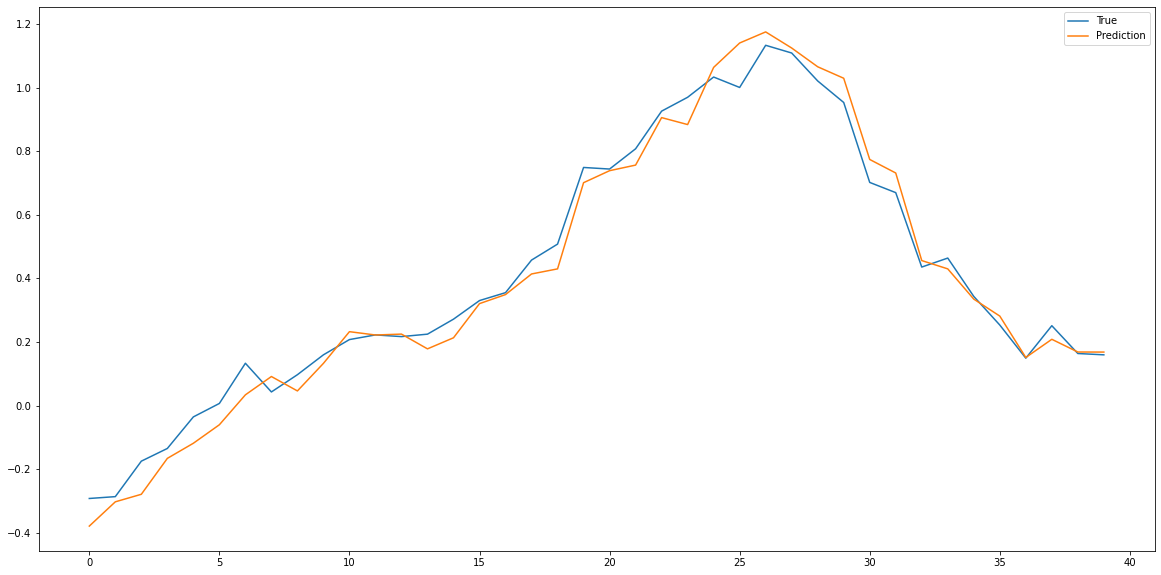

In [27]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()